In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook

In [9]:
data_dir = Path(os.getcwd()).parents[1]/'data/pytorch'
data_dir.mkdir()

In [3]:
import torch
import torchvision
import torchvision.transforms as transfroms

In [14]:
transform = transfroms.Compose(
    [transfroms.ToTensor(),
    transfroms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(root=str(data_dir), train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root=str(data_dir), train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
def imshow(img):
    img = img / 2 + .5 # nunormalize
    npimg = img.numpy() # to change numpy from torch Tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # to change (x, y, color)

In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [35]:
images?

In [22]:
images.shape

torch.Size([4, 3, 32, 32])

In [24]:
grid_images = torchvision.utils.make_grid(images)
grid_images.shape

torch.Size([3, 36, 138])

In [29]:
grid_images = grid_images / 2 + .5
npimg = grid_images.numpy()

In [32]:
npimg.shape

(3, 36, 138)

In [34]:
np.transpose(npimg, (1, 2, 0)).shape

(36, 138, 3)

plane   dog truck plane


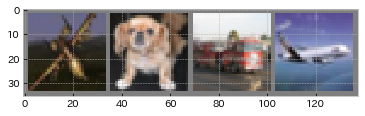

In [38]:
grid_images = torchvision.utils.make_grid(images)
imshow(grid_images)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [61]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [63]:
net = Net()

In [64]:
import torch.optim as optim

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [66]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics 
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.180
[1,  4000] loss: 1.830
[1,  6000] loss: 1.655
[1,  8000] loss: 1.581
[1, 10000] loss: 1.503
[1, 12000] loss: 1.474
[2,  2000] loss: 1.374
[2,  4000] loss: 1.358
[2,  6000] loss: 1.329
[2,  8000] loss: 1.320
[2, 10000] loss: 1.298
[2, 12000] loss: 1.266


GroundTruth:   deer  bird horse   cat


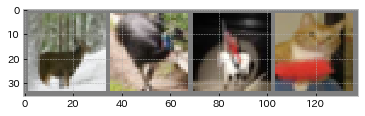

In [67]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [68]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer  deer   cat   cat


In [71]:
correct = 0
total = 0

with torch.no_grad(): # ?
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [88]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 71 %
Accuracy of  bird : 29 %
Accuracy of   cat : 36 %
Accuracy of  deer : 61 %
Accuracy of   dog : 51 %
Accuracy of  frog : 64 %
Accuracy of horse : 63 %
Accuracy of  ship : 63 %
Accuracy of truck : 54 %
